In [123]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import logging
import argparse
import math
log_filename = datetime.datetime.now().strftime(".log/%Y-%m-%d_%H_%M_%S.log")
os.makedirs(os.path.dirname(log_filename), exist_ok=True)
logging.basicConfig(level=logging.DEBUG,
                 format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                 datefmt='%m-%d %H:%M:%S',
                 filename=log_filename)
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)

In [124]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        if 0.1*i == 0.5:
            continue

        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)

    return np.array(inputs), np.array(labels).reshape(21, 1)

In [125]:
def show_result(x, y, pred_y):
    plt.subplot(1, 2, 1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')

    plt.subplot(1, 2, 2)
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')

    plt.show()

![Backpropagation pseudo code](images/backprop-pseudo-code.png)


Sigmoid Function: $ \sigma(x) = \frac{1}{1 + e^{-x}} $  
Derivate of Sigmoid Function: $ \frac{d\sigma(x)}{d(x)} = \sigma(x) \cdot (1 - \sigma(x)) $  
https://www.latex4technics.com/codesearch

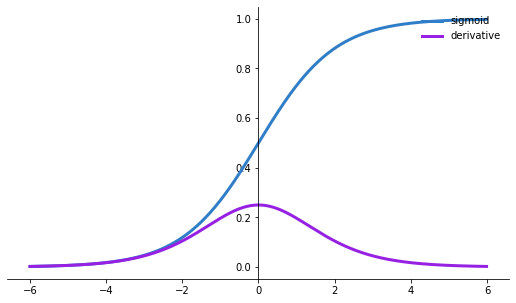

In [126]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

def derivative(f, *args):
    x = f(args[0])
    return np.multiply(x, 1.0 - x)

def derivative_sigmoid(x):
    return np.multiply(sigmoid(x), 1.0 - sigmoid(x))
    

def mse(y_pred, y_data, derivative=False):
    return (np.square(y_pred - y_data)).mean()

def show_sigmoid():
    # https://medium.com/@omkar.nallagoni/activation-functions-with-derivative-and-python-code-sigmoid-vs-tanh-vs-relu-44d23915c1f4
    x=np.arange(-6,6,0.01)
    # Setup centered axes
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    # Create and show plot
    ax.plot(x, sigmoid(x), color="#307EC7", linewidth=3, label="sigmoid")
    ax.plot(x, derivative(sigmoid, x), color="#9621E2", linewidth=3, label="derivative")
    ax.legend(loc="upper right", frameon=False)
    plt.show()
    
show_sigmoid()

In [137]:
class Net:
    def __init__(self, dim, activation=sigmoid, loss=mse):
        def init_weights(d):
            np.random.seed(9487)
            input_size, output_size = d
            weights = np.random.randn(input_size, output_size) * 0.1
            #logging.debug('init weight dimension', d, 'weights', weights)
            return weights
        
        self.layers = [None] * len(dim)
        self.weights = [init_weights(d) for d in zip(dim[:-1], dim[1:])]
        print(self.weights)
        self.act = activation
        self.loss = loss

    def predict(self, X):
        Z = X
        for i, W in enumerate(self.weights):
            # @ is matrix multiplication operator
            #logging.debug('layer', i)
            #logging.debug('Z', Z)
            #logging.debug('W', W)
            Z = self.act(Z @ W)
            self.layers[i+1] = np.array(Z)
        return Z

    def backprop(self, y_data):
        Z = y_data
        dz = derivative(self.act, Z)
        dW = []
        dZ = []
        for i, W in reversed(list(enumerate(self.weights))):
            # dw = dL / dW
            dw = np.kron(Z.T, dz)
            dW.append(np.array(dw))
            dz = np.multiply(dz @ W.T, derivative(self.act, Z))
            dZ.append(np.array(dz))
        return dW

    def update(self, lr, dW):
        for i, dw in reversed(list(enumerate(dW))):
        #for weight, dw in enumerate(zip(self.weights, dW)):
            self.weights[i] -= lr * dw

In [138]:
nn = Net(dim=[2, 3, 3, 1])
X, Y = generate_XOR_easy()

lr, epoch, done = 0.8, 0, False
while not done:
    loss = []
    for x, y in zip(X, Y):
        x, y = x.reshape(1, -1), y.reshape(1, -1)
        y_pred = nn.predict(x)
        #logging.debug('y', y, 'y_pred', y_pred)
        dW = nn.backprop(y)
        nn.update(lr, dW)
        loss += [mse(y_pred, y)]
        epoch += 1
        if epoch % 5000 == 0:
            print('epoch: {}, loss: {}'.format(epoch, loss[-1]))
    done = all(np.array(loss) < 0.04)

Y_pred = [int(nn.predict(x.reshape(1, -1)) >= 0.5) for x in X]
show_result(X, Y, Y_pred)

[array([[ 0.02839929,  0.02600207, -0.10408537],
       [-0.01834751,  0.00644143,  0.02419577]]), array([[ 0.02839929,  0.02600207, -0.10408537],
       [-0.01834751,  0.00644143,  0.02419577],
       [ 0.03475003,  0.12065913, -0.13146417]]), array([[ 0.02839929],
       [ 0.02600207],
       [-0.10408537]])]
dw [[0.]]
dw arr [[0.]]
dw [[ 0.  0. -0.]]
dw arr [[ 0.  0. -0.]]
dw [[ 0. -0.  0.]]
dw arr [[ 0. -0.  0.]]


ValueError: non-broadcastable output operand with shape (3,1) doesn't match the broadcast shape (3,3)

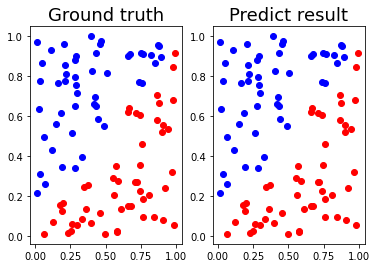

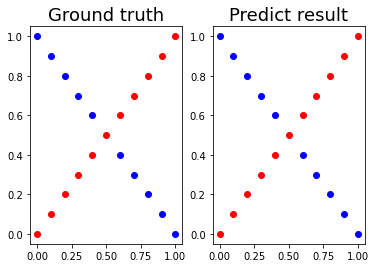

In [7]:
nn = Net(dim=[2, 3, 3, 1])
lr, epoch, done = 0.8, 0, False
X, Y = generate_linear()
while not done:
    loss = []
    for x, y in ZIP(X, Y):
        x, y = x.reshape(1, -1), y.reshape(1, -1)
        y_pred = nn.predict(x)
        nn.backprop(y)
        nn.update(lr)
        loss += [mse(y_pred, y)]
        epoch += 1
        if epoch % 5000 == 0:
            logging.info('epoch: %d, loss: %f', epoch, loss[-1])
    done = all(np.array(loss) < 0.04)

Y_pred = [int(nn.predict(x.reshape(1, -1)) >= 0.5) for x in X]
show_result(X, Y, Y_pred)